In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import seaborn as sns
sns.set()
import pandas as pd
import gc
gc.collect()
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from tqdm import tqdm
#### Download data for fare_estimates_count_last_ride_date_for_churned_customer

from pyhive import presto
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
requests.packages.urllib3.disable_warnings()
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import gc
gc.collect()
gc.collect()

tqdm.pandas()

/home/ronak/anaconda3/envs/customer_v1/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# from pyhive import presto
# import requests
# from requests.auth import HTTPBasicAuth
# import pandas as pd
# requests.packages.urllib3.disable_warnings()
# import matplotlib.pyplot as plt
# import datetime as dt
# import numpy as np
# import gc
# gc.collect()
# gc.collect()

# tqdm.pandas()
# conn = presto.connect(
#     host='10.160.0.62',
#     port=8060,
#     protocol='http',
#     catalog='hive',
#     schema='mongodb',
#     username='ronak',
#     # requests_kwargs=req_kw,
# )
# order_date_query_test = """Select updatedAt,customer,status,orderdate,serviceobj_city,spdfraud_flag
# from hive.mongodb.orders 
# where (orderdate =  '2020-01-02') and (status ='dropped')
# """
# df_order_date_test = pd.read_sql(order_date_query_test, conn)
# df_order_date_test.to_csv('orders_2_jan_all_india.csv')



In [4]:
orders=pd.read_csv('orders_2_jan_all_india.csv')

In [5]:
def drop_unnamed(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [6]:
orders=drop_unnamed(orders)

In [7]:
orders.head()
orders.shape

,updatedAt,customer,status,orderdate,serviceobj_city,spdfraud_flag
0,"[{'_id': ObjectId('5e0df1f2909fff3c990e074e'),...",5886149e670c2b384af6ca40,dropped,2020-01-02,Warangal,0
1,"[{'_id': ObjectId('5e0df1f24f3c88109ae0a666'),...",5886149e670c2b384af6ca40,dropped,2020-01-02,NCR,0
2,"[{'_id': ObjectId('5e0df1f36d26d03cbb1e636c'),...",5e0de9fb39136622c07a317b,dropped,2020-01-02,Jodhpur,0
3,"[{'_id': ObjectId('5e0df1f3b68f0c4dcf932fef'),...",5d08a29d57152c471e02c0e1,dropped,2020-01-02,Lucknow,0
4,"[{'_id': ObjectId('5e0df1f35470093189df7bdb'),...",5e04acf810e94832d1721a5d,dropped,2020-01-02,Lucknow,0


(313820, 6)

In [8]:
orders.iloc[4]

updatedAt          [{'_id': ObjectId('5e0df1f35470093189df7bdb'),...
customer                                    5e04acf810e94832d1721a5d
status                                                       dropped
orderdate                                                 2020-01-02
serviceobj_city                                              Lucknow
spdfraud_flag                                                      0
Name: 4, dtype: object

In [9]:
updated_at_split=orders['updatedAt'].progress_apply(lambda x: x.strip('[]'))

100%|██████████| 313820/313820 [00:00<00:00, 423646.21it/s]


In [10]:
updated_at_split.iloc[5]

"{'_id': ObjectId('5e0df1f3e88e593c9497a79e'), 'status': 'new', 'updatedAt': 1577972211443.0}, {'_id': ObjectId('5e0df1fce9214b4dd411b968'), 'status': 'riderRejected', 'updatedAt': 1577972220236.0, 'rider': ObjectId('5db07f7d25a28c419c9a6d03')}, {'_id': ObjectId('5e0df202cd783a10c0ed03c4'), 'status': 'notReachedToRider', 'updatedAt': 1577972226803.0, 'rider': ObjectId('5c66c12af2edc733675abb47')}, {'_id': ObjectId('5e0df214e9214b4dd411ba27'), 'status': 'onTheWay', 'updatedAt': 1577972244637.0, 'captainApp': {'appId': '1', 'version': 235}, 'rider': ObjectId('5c66c12af2edc733675abb47'), 'info': 'batteryPercentage:45'}, {'_id': ObjectId('5e0df4b95470093189df92ba'), 'status': 'arrived', 'updatedAt': 1577972921655.0, 'rider': ObjectId('5c66c12af2edc733675abb47')}, {'_id': ObjectId('5e0df60cee7a7131a6482596'), 'status': 'started', 'updatedAt': 1577973260805.0, 'rider': ObjectId('5c66c12af2edc733675abb47')}, {'_id': ObjectId('5e0df8f4e88e593c9497e0f9'), 'status': 'dropped', 'updatedAt': 15779

In [11]:
import re
def extract_epoch_timestamp(a):
    m = re.search('[0-9]{3,}.[0-9]{1}', a)
    if m:
        found = m.group(0)
        return found

def get_request_time_otw_time(each_cell):
    split_list=each_cell.split(',')
    new_order_index=split_list.index(" 'status': 'new'")+1
    request_time=float(extract_epoch_timestamp(split_list[new_order_index]))
    otw_index=split_list.index(" 'status': 'onTheWay'")+1
    otw_time=float(extract_epoch_timestamp(split_list[otw_index]))
    return request_time,otw_time

In [12]:
updated_at_v2=updated_at_split.progress_apply(get_request_time_otw_time)
order_time=pd.DataFrame(updated_at_v2.tolist(), index=updated_at_v2.index,columns=['request_time','otw_time'])  

def epoch_to_IST(epoch_value_series):
    return pd.to_datetime(epoch_value_series+ float(19805000),unit='ms')

def get_request_time_otw_time_ist(order_time):
    order_time.loc[:,'request_time_ist']=epoch_to_IST(order_time['request_time'])
    order_time.loc[:,'otw_time_ist']=epoch_to_IST(order_time['otw_time'])
    return order_time[['request_time_ist','otw_time_ist']]

order_time.head(2)
order_time_ist=get_request_time_otw_time_ist(order_time)
order_time_ist.head(2)
order_time_ist.loc[:,'total_time']=((order_time_ist['otw_time_ist']-order_time_ist['request_time_ist']).dt.seconds)
order_time_ist.loc[:,'time_to_accept']=order_time_ist['total_time']%25
order_time_ist.head(2)

100%|██████████| 313820/313820 [00:02<00:00, 133286.15it/s]


,request_time,otw_time
0,1.577972e+12,1.577972e+12
1,1.577972e+12,1.577972e+12


,request_time_ist,otw_time_ist
0,2020-01-02 19:06:55.461,2020-01-02 19:07:01.500
1,2020-01-02 19:06:55.514,2020-01-02 19:07:03.526


/home/ronak/anaconda3/envs/customer_v1/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ronak/anaconda3/envs/customer_v1/lib/python3.7/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,request_time_ist,otw_time_ist,total_time,time_to_accept
0,2020-01-02 19:06:55.461,2020-01-02 19:07:01.500,6,6
1,2020-01-02 19:06:55.514,2020-01-02 19:07:03.526,8,8


#### merge city with split

In [13]:
order_time_ist_city=pd.concat([order_time_ist,orders['serviceobj_city']],axis=1)
order_time_ist_city.head(2)

,request_time_ist,otw_time_ist,total_time,time_to_accept,serviceobj_city
0,2020-01-02 19:06:55.461,2020-01-02 19:07:01.500,6,6,Warangal
1,2020-01-02 19:06:55.514,2020-01-02 19:07:03.526,8,8,NCR


In [14]:
order_time_ist_city.to_csv('order_time_ist_city.csv',index=False)

### RERun here

In [15]:
order_time_ist_city.head(2)

,request_time_ist,otw_time_ist,total_time,time_to_accept,serviceobj_city
0,2020-01-02 19:06:55.461,2020-01-02 19:07:01.500,6,6,Warangal
1,2020-01-02 19:06:55.514,2020-01-02 19:07:03.526,8,8,NCR


In [16]:
def get_time_to_accept(order_time_ist):
    a=order_time_ist['time_to_accept'].value_counts().sort_index()\
                                    .reset_index().rename(columns={'index':'time_in_secs','time_to_accept':'number_of_orders'})
    a.loc[:,'perc_of_orders']=round((a['number_of_orders']/a['number_of_orders'].sum())*100,2)
    return a

In [17]:
def get_time_to_accept_for_city(city):
    time_to_accept=get_time_to_accept(order_time_ist_city[order_time_ist_city['serviceobj_city']==city])
    time_to_accept.loc[:,'city']=city
    return time_to_accept


In [18]:
# city_list=order_time_ist_city['serviceobj_city'].unique()
city_list=[
    'Hyderabad',
    'Bangalore',
    'Kolkata',
    'NCR',
    'Chennai',
    'Indore'
]

In [19]:
res=[]
[res.append(get_time_to_accept_for_city(city)) for city in city_list]

[None, None, None, None, None, None]

In [46]:
def get_90_perc_time_for_city(city):
    print('======{0}====='.format(city))
    print(order_time_ist_city[order_time_ist_city['serviceobj_city']==city]['time_to_accept'].describe(percentiles=[0.6,0.7,0.75,0.8,0.9,0.95]))
# get_90_perc_time_for_city('NCR')

In [47]:
city_wise_split=pd.concat(res)
import plotly.express as px
fig = px.bar(city_wise_split, x='time_in_secs', y='perc_of_orders',color='city')
fig.show()
[get_90_perc_time_for_city(city) for city in city_list]

======Hyderabad=====
count    52884.000000
mean        11.004916
std          5.550130
min          0.000000
50%         10.000000
60%         12.000000
70%         14.000000
75%         15.000000
80%         16.000000
90%         19.000000
95%         21.000000
max         24.000000
Name: time_to_accept, dtype: float64
======Bangalore=====
count    58082.000000
mean        11.412073
std          5.802776
min          0.000000
50%         11.000000
60%         13.000000
70%         14.000000
75%         16.000000
80%         17.000000
90%         20.000000
95%         22.000000
max         24.000000
Name: time_to_accept, dtype: float64
======Kolkata=====
count    19630.000000
mean        12.159908
std          6.121692
min          0.000000
50%         12.000000
60%         14.000000
70%         16.000000
75%         17.000000
80%         18.000000
90%         21.000000
95%         22.000000
max         24.000000
Name: time_to_accept, dtype: float64
======NCR=====
count    14067.000000

[None, None, None, None, None, None]

In [50]:
city_wise_split=pd.concat(res)
import plotly.express as px
fig = px.bar(city_wise_split, x='time_in_secs', y='perc_of_orders',color='city',title='Time to Accept order by Captain')
fig.show()
[get_90_perc_time_for_city(city) for city in city_list]

======Hyderabad=====
count    52884.000000
mean        11.004916
std          5.550130
min          0.000000
50%         10.000000
60%         12.000000
70%         14.000000
75%         15.000000
80%         16.000000
90%         19.000000
95%         21.000000
max         24.000000
Name: time_to_accept, dtype: float64
======Bangalore=====
count    58082.000000
mean        11.412073
std          5.802776
min          0.000000
50%         11.000000
60%         13.000000
70%         14.000000
75%         16.000000
80%         17.000000
90%         20.000000
95%         22.000000
max         24.000000
Name: time_to_accept, dtype: float64
======Kolkata=====
count    19630.000000
mean        12.159908
std          6.121692
min          0.000000
50%         12.000000
60%         14.000000
70%         16.000000
75%         17.000000
80%         18.000000
90%         21.000000
95%         22.000000
max         24.000000
Name: time_to_accept, dtype: float64
======NCR=====
count    14067.000000

[None, None, None, None, None, None]

<Figure size 1008x360 with 0 Axes>

Text(0.5, 1.0, 'City Wise : # of orders on x, effective time to accept on y')

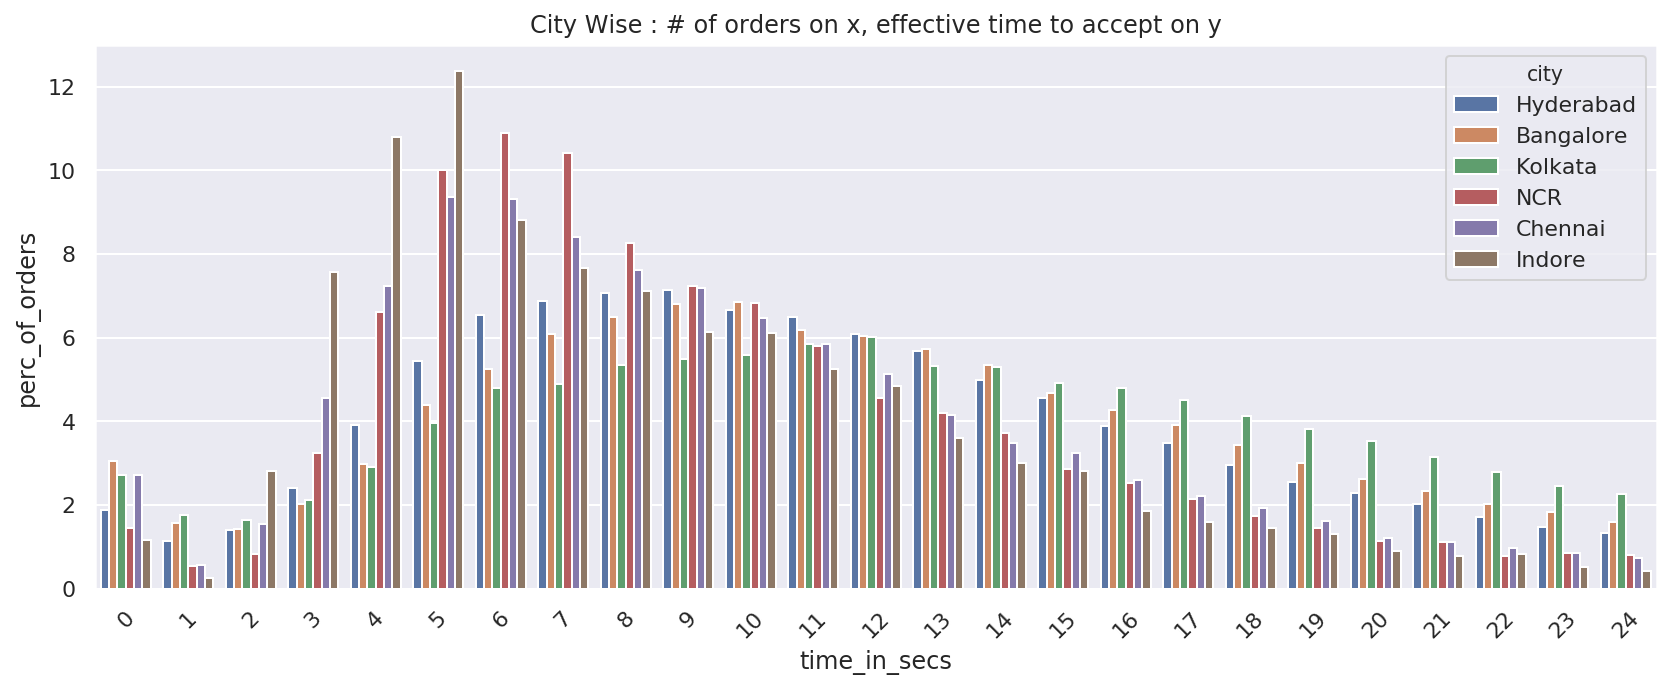

In [49]:
plt.figure(figsize=(14,5))
bar=sns.barplot(x='time_in_secs',y='perc_of_orders',hue='city',data=city_wise_split)
a=bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar.set_title('City Wise : # of orders on x, effective time to accept on y')

In [34]:
# !conda install -c plotly plotly=4.5.0 -y

In [35]:
order_time_ist.to_csv('order_time_ist.csv',index=False)

In [36]:
accept_time_dist=order_time_ist['time_to_accept'].value_counts().sort_index()\
                                .reset_index().rename(columns={'index':'time_in_secs','time_to_accept':'number_of_orders'})

<Figure size 1008x360 with 0 Axes>

Text(0.5, 1.0, 'PAN INDIA :  effective time to accept on y,# of orders on y')

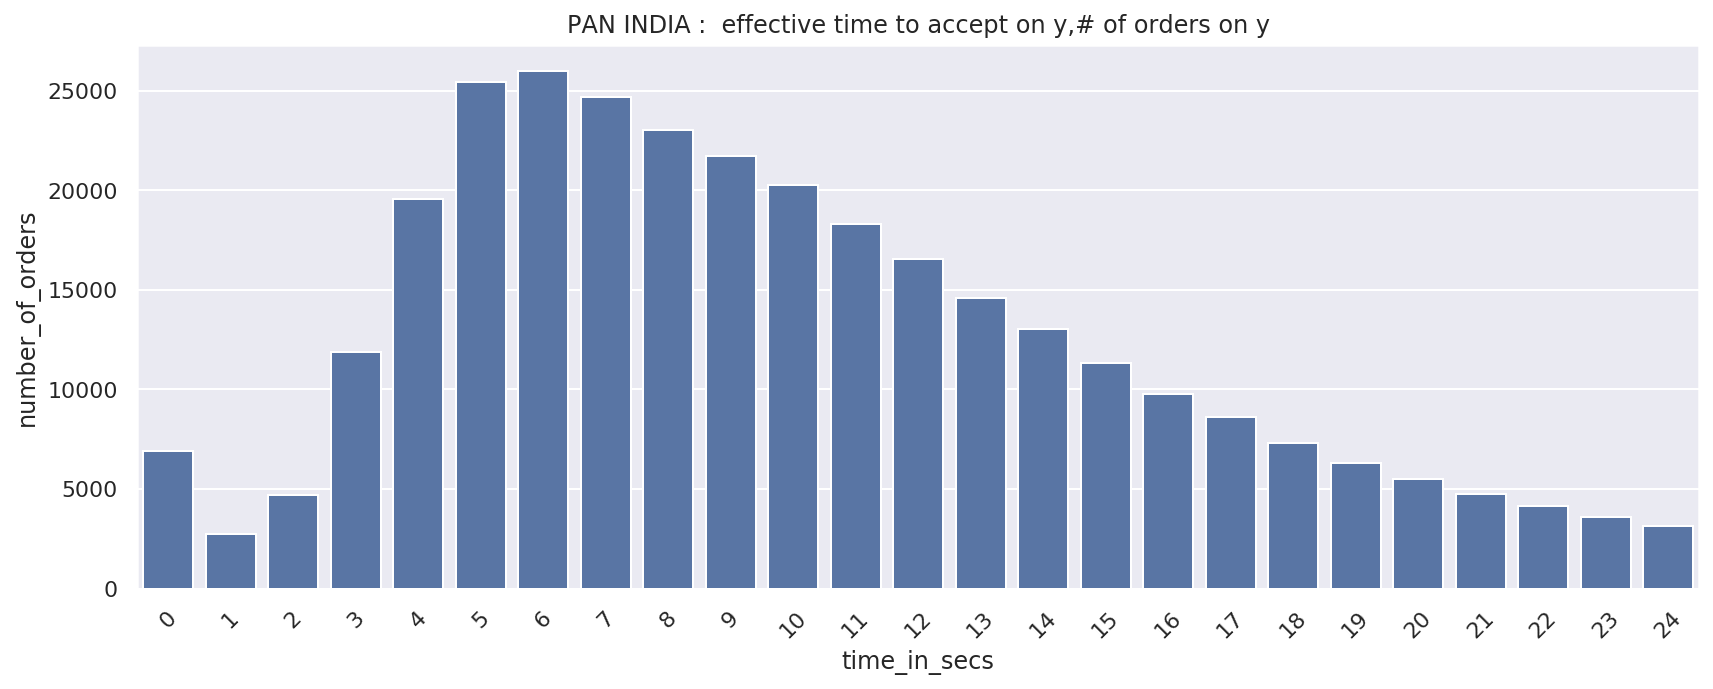

In [37]:
plt.figure(figsize=(14,5))
bar=sns.barplot(x='time_in_secs',y='number_of_orders',data=accept_time_dist,color='C0')
a=bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar.set_title('PAN INDIA :  effective time to accept on y,# of orders on y')

In [38]:
order_time_ist.shape

(313820, 4)

count    313820.000000
mean          9.941935
std           5.441962
min           0.000000
50%           9.000000
60%          11.000000
70%          12.000000
80%          15.000000
90%          18.000000
95%          20.000000
max          24.000000
Name: time_to_accept, dtype: float64

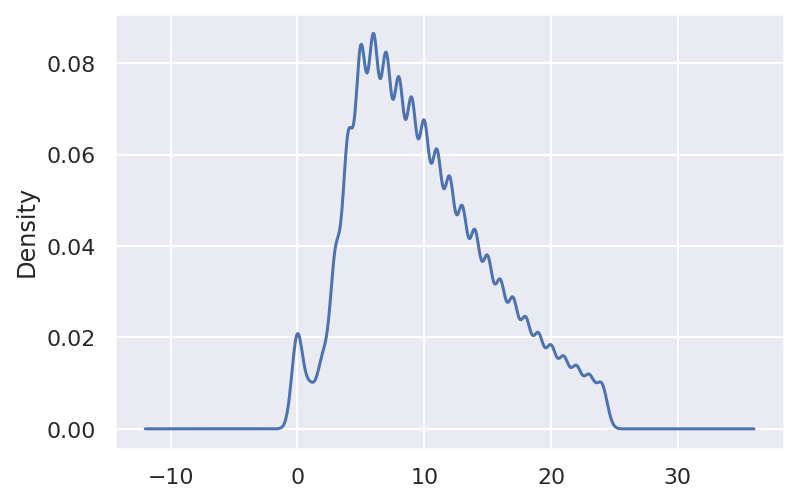

In [39]:
order_time_ist['time_to_accept'].describe(percentiles=[0.6,0.7,0.8,0.9,0.95])
s=order_time_ist['time_to_accept']
s.plot.kde()

In [40]:
accept_time_dist=order_time_ist['time_to_accept'].value_counts().sort_index()\
                                .reset_index().rename(columns={'index':'time_in_secs','time_to_accept':'number_of_orders'})

In [41]:
accept_time_dist.head()

,time_in_secs,number_of_orders
0,0,6891
1,1,2742
2,2,4712
3,3,11859
4,4,19543


<Figure size 1008x360 with 0 Axes>

Text(0.5, 1.0, 'PAN INDIA : # of orders on x, effective time to accept on y')

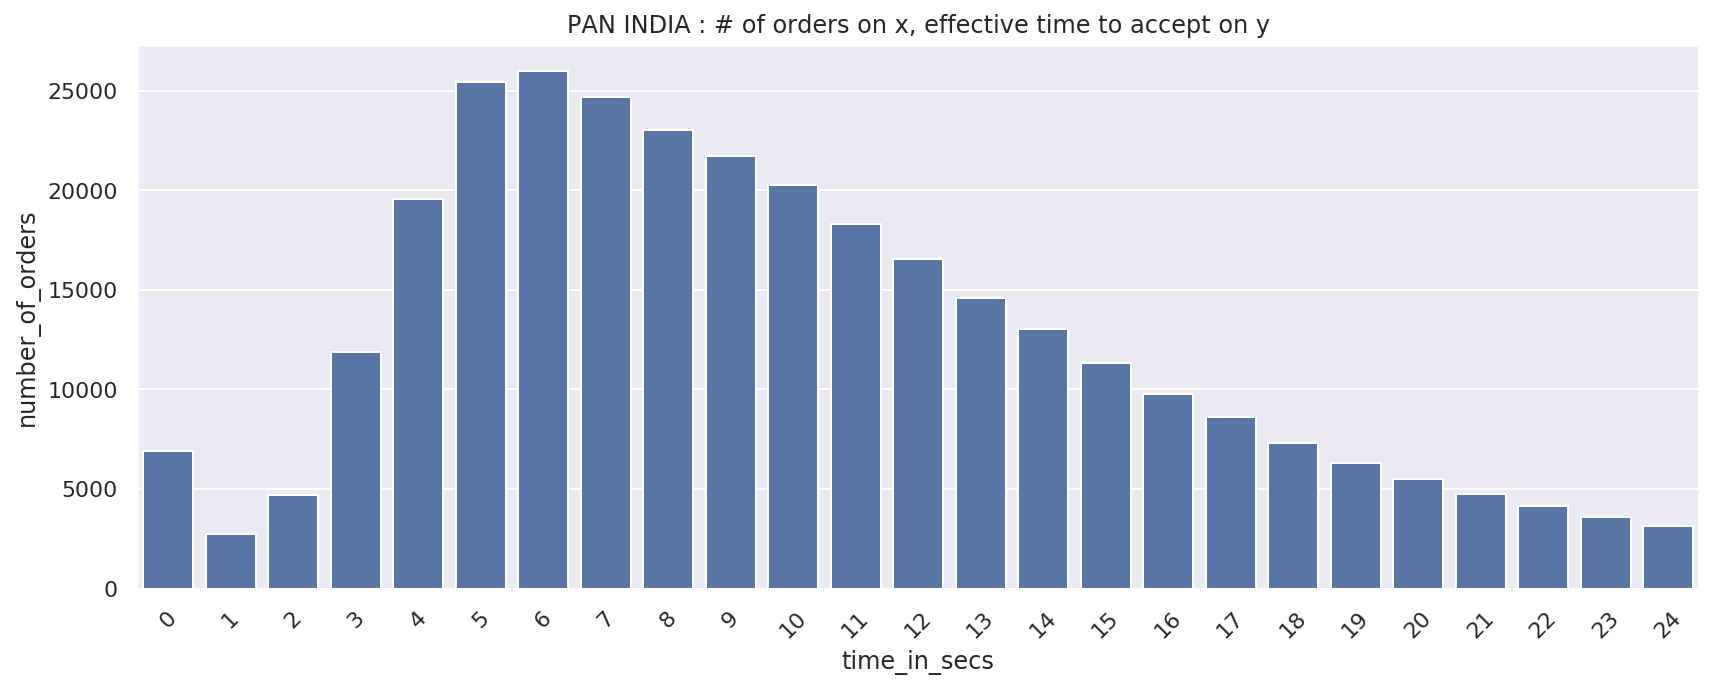

In [42]:
plt.figure(figsize=(14,5))
bar=sns.barplot(x='time_in_secs',y='number_of_orders',data=accept_time_dist,color='C0')
a=bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar.set_title('PAN INDIA : # of orders on x, effective time to accept on y')

In [43]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(1347517491.247))

NameError: name 'time' is not defined

In [44]:
import datetime
t=float('1580550534230.0')
t
datetime.datetime.fromtimestamp(t/1000)

1580550534230.0

datetime.datetime(2020, 2, 1, 9, 48, 54, 230000)

In [45]:
import time
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime('1580550534230.0'))

TypeError: an integer is required (got type str)

In [ ]:
a=" 'updatedAt': 1580550495550.0}"

In [ ]:

/